## Code to save to google driver

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


In [ ]:
%cd /content/drive/My\ Drive/Colab\ Notebooks/YOLO/Mask_detector_proj3/darknet
%ls   

/content/drive/My Drive/Colab Notebooks/YOLO/Mask_detector_proj3/darknet
3rdparty/                       net_cam_v3.sh
backup/                         obj/
bad.list                        obj.data
build/                          obj.names
build_log.txt                   out-vid1_v4.avi
build.ps1                       predictions.jpg
build.sh                        README.md
cfg/                            results/
chart.png                       scripts/
chart_yolov3-masks-train2.png   src/
chart_yolov3-masks-train3.png   test-image1.jpg
chart_yolov4-obj.png            test-image2.jpg
class.names                     test-image3.jpg
cmake/                          test-image4.jpg
CMakeLists.txt                  test-video1.mp4
darknet                         test-video2.mp4
darknet53.conv.74               train3_log.txt
DarknetConfig.cmake.in          train_log.txt
darknet.py                      train_v4_log.txt
darknet_video.py                video_v2.sh
data/                         

In [ ]:
#!unzip kaggle_and_no-mask_dataset.zip 

## Download darknet source

In [ ]:
# !git clone https://github.com/AlexeyAB/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 13639 (delta 0), reused 2 (delta 0), pack-reused 13627
Receiving objects: 100% (13639/13639), 12.30 MiB | 4.46 MiB/s, done.
Resolving deltas: 100% (9295/9295), done.
Checking out files: 100% (2004/2004), done.


In [ ]:
# %cd darknet

## Compile Darknet source

In [ ]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

print("Building. . . It might take 2-3 minutes")

!make &> build_log.txt

Building. . . It might take 2-3 minutes


## Dataset is inside kaggle_and_no-mask_dataset dir:
* Contains Images and their normalized(0-1) annotations 
* Bonding box has- class x/W y/H w/W h/H
* class: 0-Mask, 1-No_mask 
* x,y is the BB center; w,h-BB width n height; W,H-Image Width and Heigth 
* eg: 0 0.5078125 0.530833 0.9143749999999999 0.605

## Split the dataset into 80/20- Training/Test
* Create 2 txt files with locations of test/Training imgs
  * data_test.txt  - 20% of images
  * data_train.txt - 80% of images
  
  Note: Ensure differnt file types are factored in eg: jpg, jpeg, png.

In [ ]:
import random
import os
import subprocess
import sys

image_dir = "./kaggle_and_no-mask_dataset"
f_val = open("data_test.txt", 'w')
f_train = open("data_train.txt", 'w')

path, dirs, files = next(os.walk(image_dir))
data_size = len(files)
# print ("No of files:",data_size)

ind = 0
data_test_size = int(0.2 * data_size)
test_array = random.sample(range(data_size), k=data_test_size)

count=0
for f in os.listdir(image_dir):
    if (f.split(".")[-1] == "jpg") or (f.split(".")[-1] == "jpeg") or (f.split(".")[-1] == "png"):
    #if (f.split(".")[-1] == "jpg"):
        ind += 1
        if ind in test_array:
            f_val.write(image_dir+'/'+f+'\n')
        else:
            f_train.write(image_dir+'/'+f+'\n')
#     if (f.split(".")[-1] == "jpeg"):
#       count+=1
# print (count)
f_train.close()
f_val.close()

## These are the different files and Hyperparameters values used:
* class.names
    * Mask
    * No_Mask             
* yolov3-masks-train3.cfg  (This is a copy of cfg/yolov3-voc.cfg)
    * batch=64
    * subdivisions=*16*
    * width=416
    * height=416
    * channels=3
    * momentum=0.9
    * decay=0.0005
    * angle=0
    * saturation=1.5
    * learning_rate=0.001
    * burn_in=100
    * max_batches=4000
    * policy=steps
    * steps=2000
    * scales=.1

* yolov3-masks-test3.cfg  
    * batch=1
    * subdivisions=1

* darknet53.conv.74 (Pretrained weights from ImageNet)

* obj.data 
    * classes= 2
    * train  = data_train.txt
    * valid = data_test.txt
    * names = obj.names
    * backup = backup/ 

* yolov3-masks-setup.data 
    * classes= 2
    * train  = data_train.txt
    * valid = data_test.txt
    * names = class.names
    * backup = backup/ 

## Download pre-trained weights(from ImageNet) to start with default weights for training YOLO.

In [ ]:
!wget "https://www.dropbox.com/s/18dwbfth7prbf0h/darknet53.conv.74?dl=1" -O darknet53.conv.74

In [ ]:
!ls

3rdparty	   DarknetConfig.cmake.in      net_cam_v3.sh
backup		   darknet.py		       obj
bad.list	   darknet_video.py	       README.md
build		   data			       results
build_log.txt	   data_test.txt	       scripts
build.ps1	   data_train.txt	       src
build.sh	   image_yolov2.sh	       train_log.txt
cfg		   image_yolov3.sh	       video_v2.sh
class.names	   include		       video_yolov3.sh
cmake		   json_mjpeg_streams.sh       yolov3-masks-setup.data
CMakeLists.txt	   kaggle_and_no-mask_dataset  yolov3-masks-test.cfg
darknet		   LICENSE		       yolov3-masks-train.cfg
darknet53.conv.74  Makefile		       yolov3-masks.zip


## YOLO Training (takes a few hrs!)
* Once training is done the output wieghts are in ./backup/

In [ ]:
! ./darknet detector train yolov3-masks-setup.data yolov3-masks-train3.cfg backup/yolov3-masks-train2_best.weights -dont_show -map 2> train3_log.txt

Streaming output truncated to the last 5000 lines.
 total_bbox = 620819, rewritten_bbox = 0.022068 % 
 total_bbox = 620853, rewritten_bbox = 0.022066 % 
 total_bbox = 620866, rewritten_bbox = 0.022066 % 
 total_bbox = 620881, rewritten_bbox = 0.022065 % 
 total_bbox = 620916, rewritten_bbox = 0.022064 % 
 total_bbox = 621026, rewritten_bbox = 0.022060 % 
 total_bbox = 621049, rewritten_bbox = 0.022059 % 
 total_bbox = 621060, rewritten_bbox = 0.022059 % 
 total_bbox = 621074, rewritten_bbox = 0.022059 % 
 total_bbox = 621086, rewritten_bbox = 0.022058 % 
 total_bbox = 621099, rewritten_bbox = 0.022058 % 
 total_bbox = 621209, rewritten_bbox = 0.022054 % 
 total_bbox = 621255, rewritten_bbox = 0.022052 % 

 (next mAP calculation at 3800 iterations) 
 Last accuracy mAP@0.5 = 86.74 %, best = 86.74 % 
 3771: 2.165251, 1.707573 avg loss, 0.000100 rate, 24.568137 seconds, 241344 images, 1.379844 hours left
Loaded: 0.000057 seconds
 total_bbox = 621267, rewritten_bbox = 0.022052 % 
 total_bbo

## Finally Inference

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def display_output(imagePath):
    src = cv2.imread(imagePath,1)
    output = cv2.imread("predictions.jpg")

    plt.figure(figsize=[20,8])
    plt.subplot(121)
    plt.imshow(src[:,:,::-1])
    plt.title("Original Image")
    plt.subplot(122)
    plt.imshow(output[:,:,::-1])
    plt.title("Predictions")
    plt.show()

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 

 seen 64, trained: 236 K-images (3 Kilo-batches_64) 
test-image1.jpg: Predicted in 45.954000 milli-seconds.
Mask: 100%


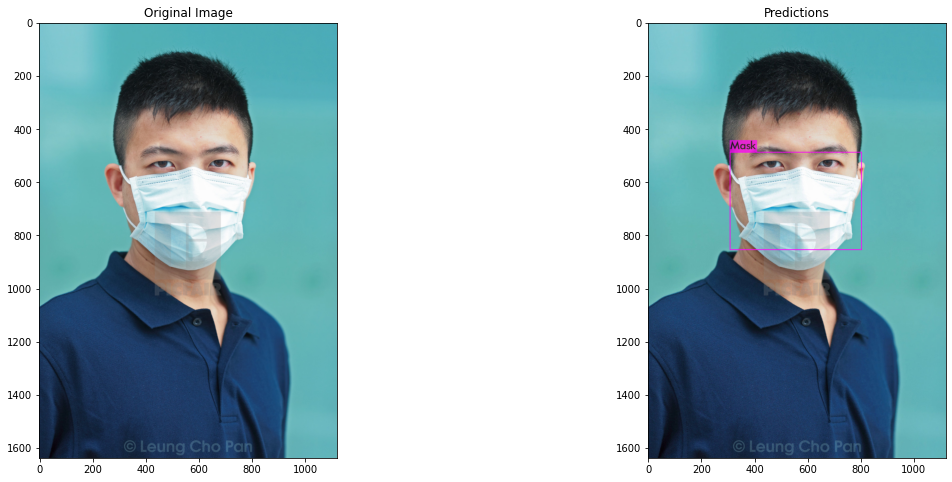

In [ ]:
# Using the wieghts from my training. Available in backup/ 
!./darknet detector test yolov3-masks-setup.data yolov3-masks-test3.cfg backup/yolov3-masks-train3_best.weights test-image1.jpg -thresh .6 2> /dev/null
display_output("test-image1.jpg")

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 

 seen 64, trained: 236 K-images (3 Kilo-batches_64) 
test-image2.jpg: Predicted in 45.836000 milli-seconds.
Mask: 98%
Mask: 99%
Mask: 81%
No_Mask: 99%
Mask: 98%


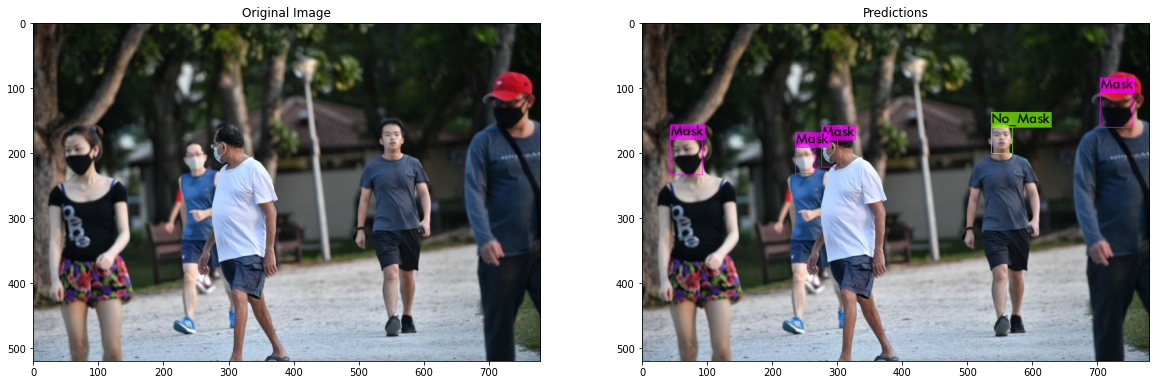

In [ ]:
# Using the wieghts from my training. Available in backup/ 
!./darknet detector test yolov3-masks-setup.data yolov3-masks-test3.cfg backup/yolov3-masks-train3_best.weights test-image2.jpg -thresh .6 2> /dev/null
display_output("test-image2.jpg")

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 

 seen 64, trained: 236 K-images (3 Kilo-batches_64) 
test-image3.jpg: Predicted in 45.846000 milli-seconds.
Mask: 76%
Mask: 100%
Mask: 100%
No_Mask: 96%
Mask: 100%
Mask: 99%
Mask: 99%
Mask: 100%
Mask: 99%
Mask: 100%
Mask: 99%
Mask: 98%
Mask: 100%
Mask: 98%
Mask: 99%
Mask: 100%
Mask: 90%
Mask: 100%
Mask: 100%


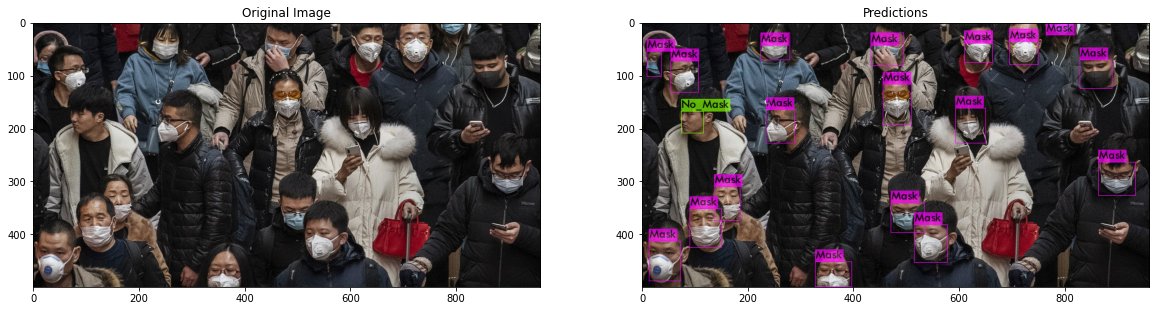

In [ ]:
# Using the wieghts from my training. Available in backup/ 
!./darknet detector test yolov3-masks-setup.data yolov3-masks-test3.cfg backup/yolov3-masks-train3_best.weights test-image3.jpg -thresh .6 2> /dev/null
display_output("test-image3.jpg")

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 

 seen 64, trained: 236 K-images (3 Kilo-batches_64) 
test-image4.jpg: Predicted in 45.916000 milli-seconds.
No_Mask: 98%
No_Mask: 85%
Mask: 99%
Mask: 100%
No_Mask: 95%
Mask: 100%
No_Mask: 81%
Mask: 100%


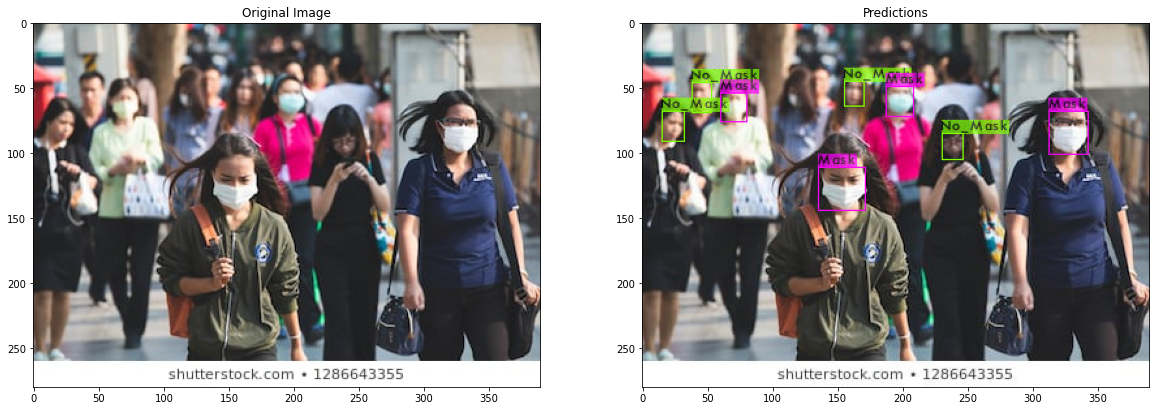

In [ ]:
# Using the wieghts from my training. Available in backup/ 
!./darknet detector test yolov3-masks-setup.data yolov3-masks-test3.cfg backup/yolov3-masks-train3_best.weights test-image4.jpg -thresh .6 2> /dev/null
display_output("test-image4.jpg")

In [ ]:
!./darknet detector demo yolov3-masks-setup.data yolov3-masks-test3.cfg backup/yolov3-masks-train3_best.weights test-video1.mp4 -thresh .6 -out_filename out-vid-yolyov3.avi -dont_show

Streaming output truncated to the last 5000 lines.
No_Mask: 81% 
Mask: 100% 

FPS:11.9 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 100% 
No_Mask: 96% 
Mask: 100% 

FPS:11.9 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 99% 
No_Mask: 96% 
Mask: 98% 

FPS:11.9 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 97% 
No_Mask: 96% 
Mask: 98% 

FPS:12.1 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 97% 
No_Mask: 96% 
Mask: 98% 

FPS:12.0 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 95% 
No_Mask: 85% 
Mask: 99% 
Mask: 96% 

FPS:12.1 	 AVG_FPS:12.1

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 96% 
No_Mask: 66% 
Mask: 99% 
Mask: 98% 

FPS:12.2 	 AVG_FPS:12.1

 cvWriteFrame 
Objects:

No_Mask: 100% 
No_Mask: 100% 
No_Mask: 95% 
Mask: 100% 
Mask: 99% 

FPS:12.3 	 AVG_FPS:12.1

 cvWriteFrame 
Objects:

No_Mask: 100% 
